### Імпорт бібліотек

In [13]:
import random
import networkx as nx
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from IPython.display import Image, display
import time
import os

### Клас Create_Graph (з лабораторної №1)

In [14]:
class Create_Graph:
    def __init__(self, n, remove_edges):
        self.n = n
        self.remove_edges = remove_edges
        self.graph = None
        self.generate_graph()

    def generate_graph(self):
        self.graph = nx.grid_2d_graph(self.n, self.n)
        edges = list(self.graph.edges())
        random.shuffle(edges)

        removed = 0
        for u, v in edges:
            if removed >= self.remove_edges:
                break
            self.graph.remove_edge(u, v)
            if not nx.is_connected(self.graph):
                self.graph.add_edge(u, v)
            else:
                removed += 1
        return self.graph

    def visualization(self, filename="graph_lab3.png"):
        pos = {node: (node[1], -node[0]) for node in self.graph.nodes()}
        plt.figure(figsize=(6, 6))
        nx.draw(self.graph, pos, node_color="white", edgecolors="black", node_size=200)
        plt.axis("off")
        plt.savefig(filename, bbox_inches="tight", dpi=150)
        plt.close()
        return filename


### Клас Agent (з лабороторної №2)

In [15]:
class Agent:
    """Раціональний агент-автомобіль з обмеженим баченням."""
    def __init__(self, graph, start, goal):
        self.graph = graph
        self.start = start
        self.goal = goal
        self.position = start
        self.path = [start]
        self.visited_nodes = {start}
        self.visited_edges = set()

    def see_neighbors(self):
        """Агент бачить тільки сусідів поточного вузла."""
        return list(self.graph.neighbors(self.position))

    def move(self, next_node):
        """Рух агента: зберігаємо пройдений шлях, вузли та дороги."""
        if next_node in self.graph.neighbors(self.position):
            self.visited_edges.add((self.position, next_node))
            self.visited_edges.add((next_node, self.position))
            self.visited_nodes.add(next_node)
            self.position = next_node
            self.path.append(next_node)
        else:
            raise ValueError("Не можна рухатися до цієї вершини!")

    def heuristic(self, node):
        """Манхеттенська відстань до цілі (для вибору напрямку)."""
        return abs(node[0] - self.goal[0]) + abs(node[1] - self.goal[1])

    def decide_next(self):
        """Вибір наступного кроку: сусід, найближчий до цілі."""
        neighbors = self.see_neighbors()
        unvisited = [n for n in neighbors if n not in self.visited_nodes]
        if unvisited:
            return min(unvisited, key=lambda n: self.heuristic(n))
        else:
            if len(self.path) > 1:
                return self.path[-2]
            return self.position

    def search(self):
        """Пошук цілі з обмеженим баченням (поступово)."""
        while self.position != self.goal:
            next_node = self.decide_next()
            self.move(next_node)
        return self.path

def animate_path(self, delay=0.5):
    """Анімація руху агента."""
    folder = "graph"
    os.makedirs(folder, exist_ok=True)
    pos = {node: (node[1], -node[0]) for node in self.graph.nodes()}
    images = []

    for i in range(1, len(self.path) + 1):
        plt.figure(figsize=(6, 6))
        nx.draw(self.graph, pos, node_color="white", edgecolors="black", node_size=300)
        nx.draw_networkx_nodes(self.graph, pos, nodelist=[self.start], node_color="green", node_size=400)
        nx.draw_networkx_nodes(self.graph, pos, nodelist=[self.goal], node_color="red", node_size=400)
        if i > 1:
            edges = [(self.path[j], self.path[j + 1]) for j in range(i - 1)]
            nx.draw_networkx_edges(self.graph, pos, edgelist=edges, edge_color="orange", width=2)
        nx.draw_networkx_nodes(self.graph, pos, nodelist=[self.path[i - 1]], node_color="blue", node_size=350)
        filename = os.path.join(folder, f"step_{i}.png")
        plt.axis("off")
        plt.savefig(filename, bbox_inches="tight", dpi=120)
        plt.close()
        images.append(filename)

    for filename in images:
        display(Image(filename=filename))
        time.sleep(delay)


### Клас Knowledge_Base і Extended_Agent

In [16]:
class Knowledge_Base:
    def __init__(self):
        self.knowledge_base = {} # {position: {'neighbors': [], 'signs': {}, 'dead_end': False}}
        self.dead_nodes = set()

    def tell_kb(self, position, neighbors):
        """Додає інформацію про позицію та її сусідів."""
        if position not in self.knowledge_base:
            self.knowledge_base[position] = {'neighbors': neighbors, 'dead_end': False}
        else:
            # Оновлюємо інформацію, якщо потрібно
            self.knowledge_base[position]['neighbors'] = neighbors

    def mark_dead_end(self, position):
        """Позначає вершину як мертву точку."""
        if position in self.knowledge_base:
            self.knowledge_base[position]['dead_end'] = True
        self.dead_nodes.add(position)

    def ask_unvisited_neighbors(self, position, visited_nodes):
        """Повертає невідвіданих сусідів, які не є мертвими точками."""
        neighbors = [n for n in self.knowledge_base[position]['neighbors']
                     if n not in visited_nodes and n not in self.dead_nodes]
        return neighbors

    def check_dead_end(self, position, visited_nodes):
        """Перевіряє, чи є поточна позиція мертвою точкою."""
        if position not in self.knowledge_base:
            return False
        available_neighbors = [n for n in self.knowledge_base[position]['neighbors']
                               if n not in self.dead_nodes]
        unvisited_available = [n for n in available_neighbors if n not in visited_nodes]
        return len(unvisited_available) == 0


class Extended_Agent(Agent):
    def __init__(self, graph, start, goal):
        super().__init__(graph, start, goal)
        self.knowledge_base = Knowledge_Base()
        self.backtrack_path = [] # шлях для повернення
        self.search()
        print(self.path)

    def perceive_and_update(self):
        """Оновлюємо базу знань про сусідів та знаки."""
        neighbors = self.see_neighbors()
        self.knowledge_base.tell_kb(self.position, neighbors)
        # Перевіряємо, чи стала поточна позиція мертвою точкою
        if self.knowledge_base.check_dead_end(self.position, self.visited_nodes):
            self.knowledge_base.mark_dead_end(self.position)
            return True
        return False

    def decide_next(self):
        """Вибір наступного кроку з урахуванням мертвих точок."""
        is_dead_end = self.perceive_and_update()
        # Шукаємо невідвіданих сусідів, які не є мертвими точками
        unvisited = self.knowledge_base.ask_unvisited_neighbors(self.position, self.visited_nodes)
        if unvisited:
            return min(unvisited, key=lambda n: self.heuristic(n))
        else:
            return self.backtrack()

    def backtrack(self):
        """Повернення назад по пройденому шляху."""
        if len(self.path) > 1:
            backtrack_node = self.path[-2]
            # Перевіряємо, чи не стала попередня позиція мертвою точкою
            if backtrack_node in self.knowledge_base.dead_nodes:
                available_backtrack = [node for node in self.path[:-1]
                                       if node not in self.knowledge_base.dead_nodes]
                if available_backtrack:
                    return available_backtrack[-1]
            return backtrack_node

    def search(self):
        """Пошук цілі з обмеженим баченням та запам'ятовуванням мертвих точок."""
        self.perceive_and_update()
        while self.position != self.goal:
            next_node = self.decide_next()
            self.move(next_node)
        return self.path


### Запуск лабораторної і відображення результатів

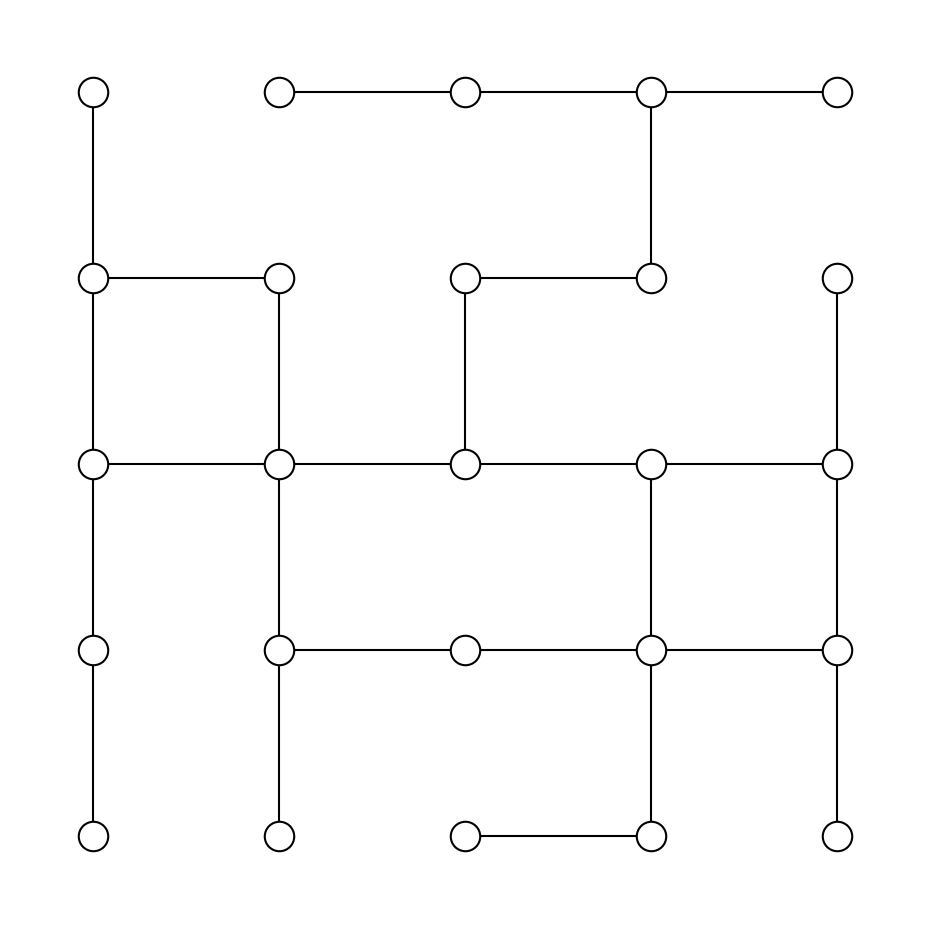

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (3, 0), (2, 0), (2, 1), (3, 1), (4, 1), (3, 1), (3, 2), (3, 3), (4, 3), (4, 2), (4, 3), (3, 3), (3, 4), (4, 4)]


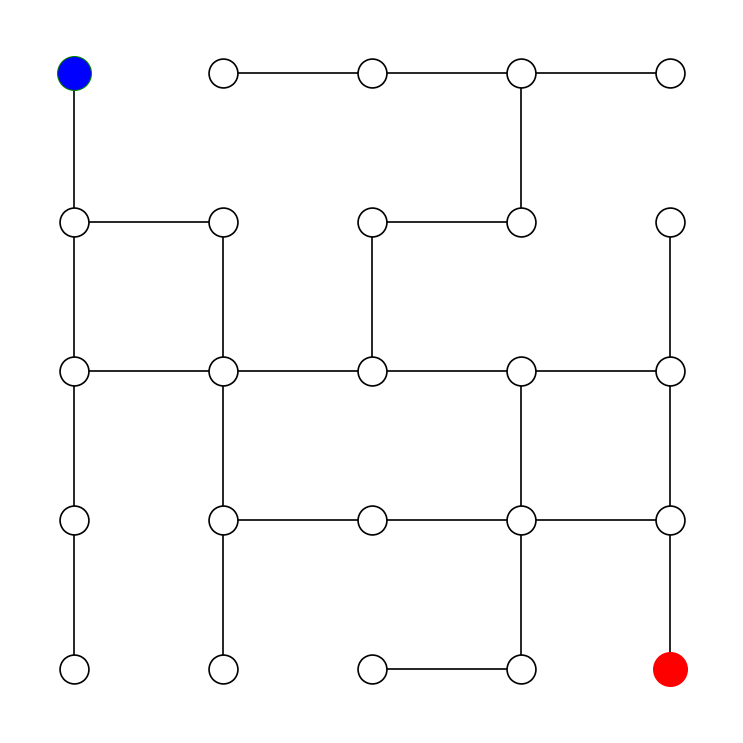

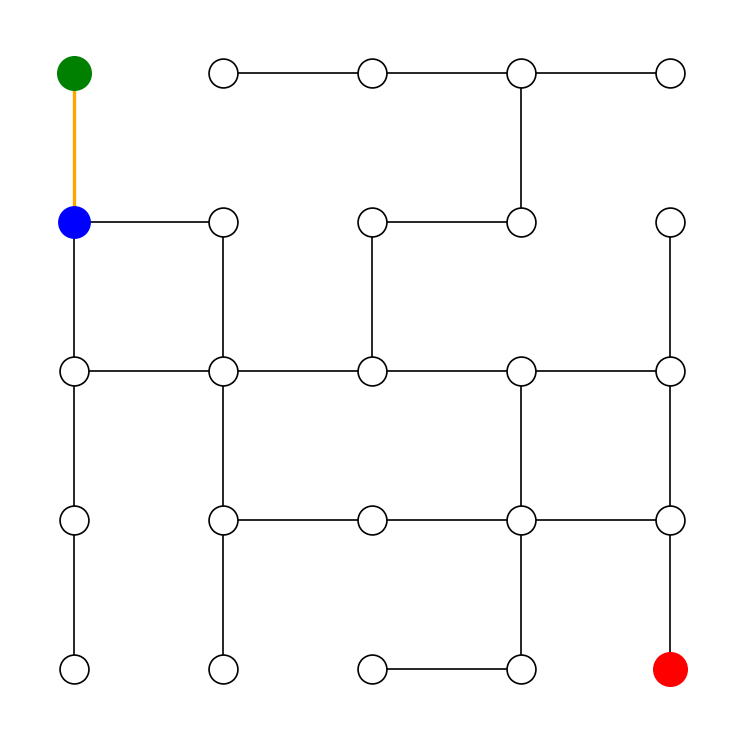

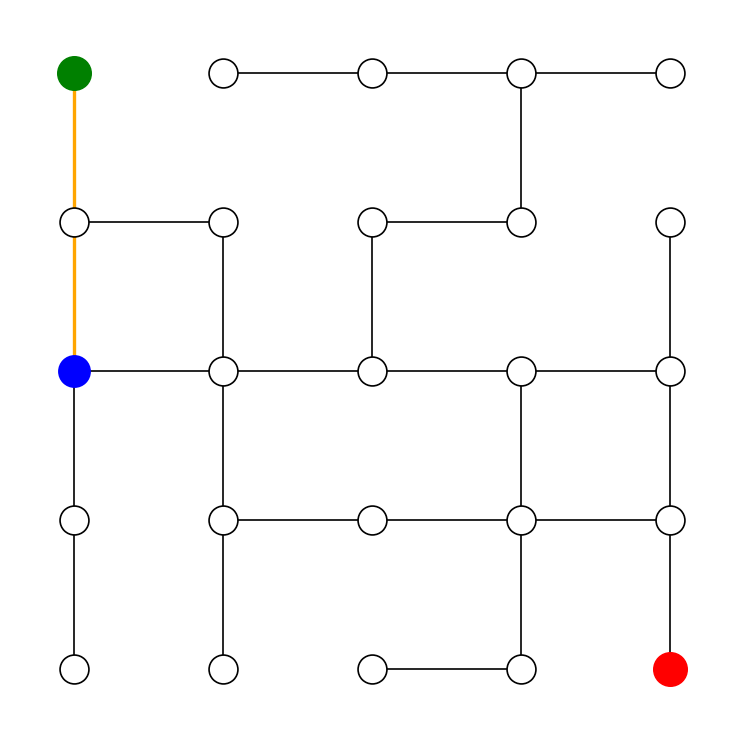

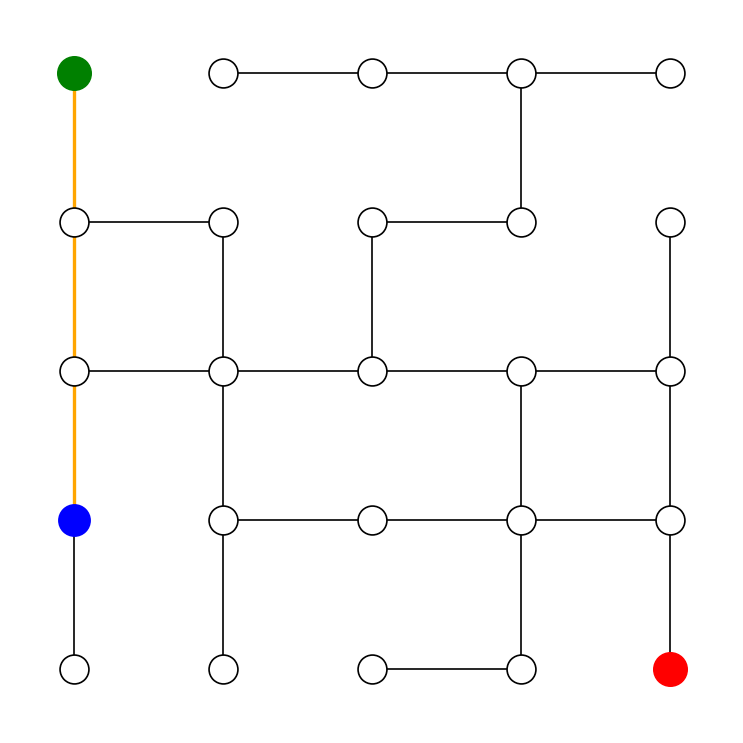

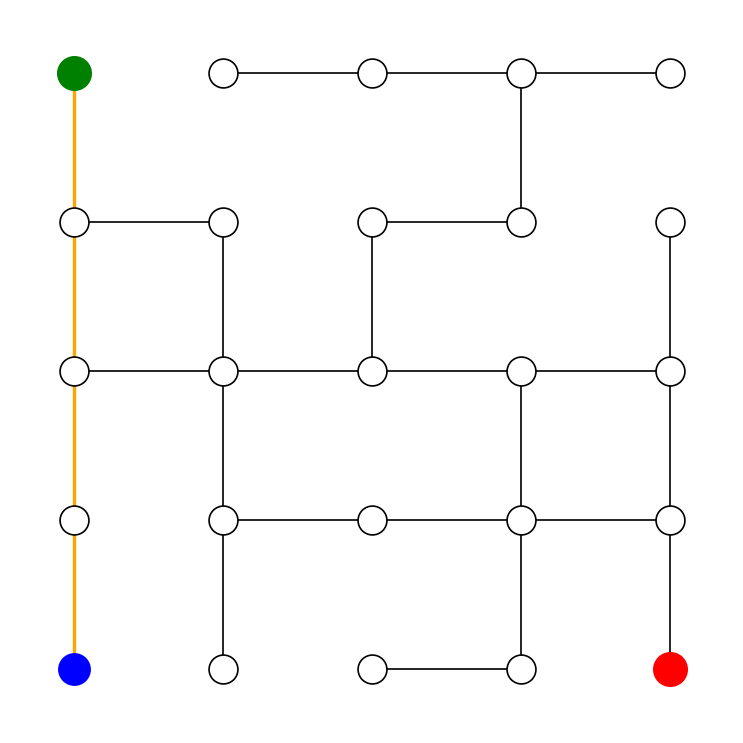

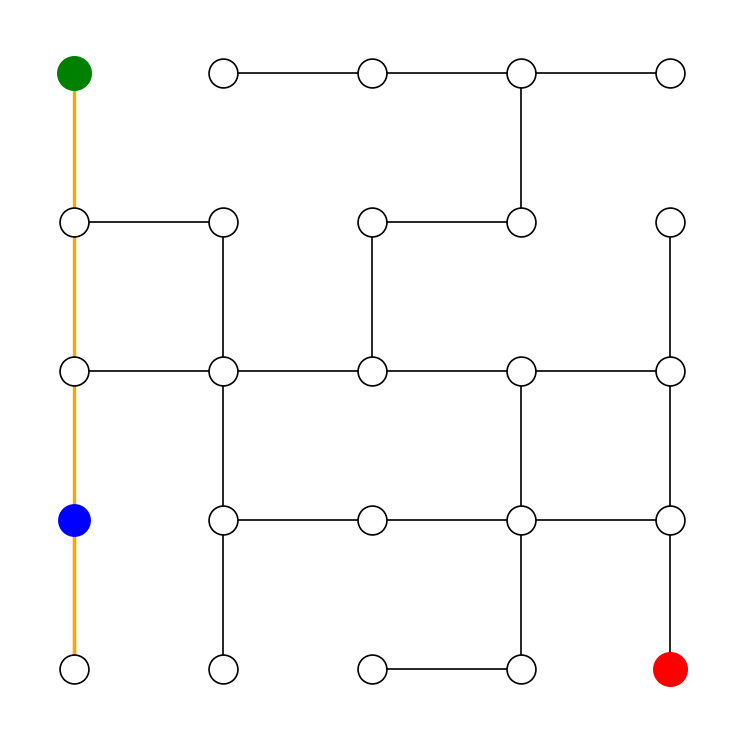

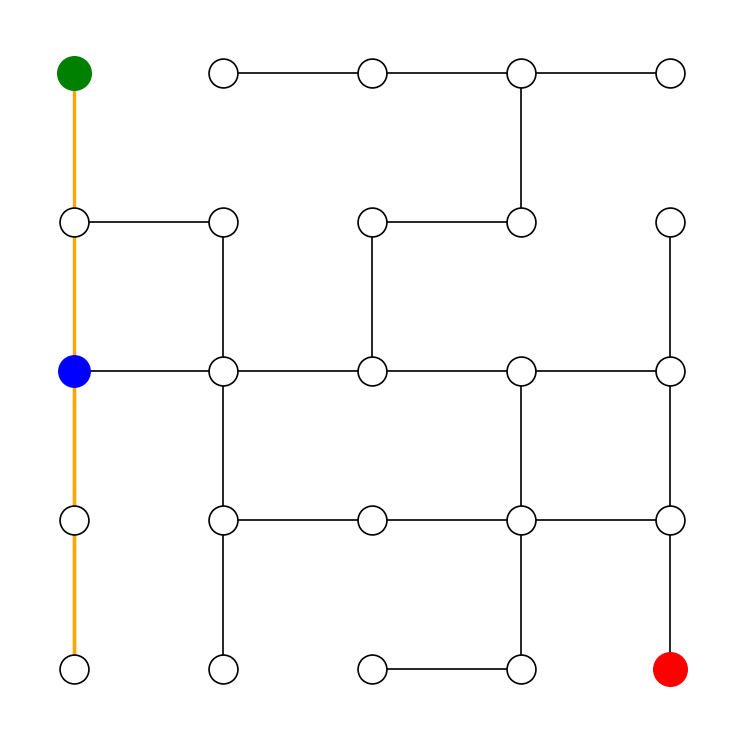

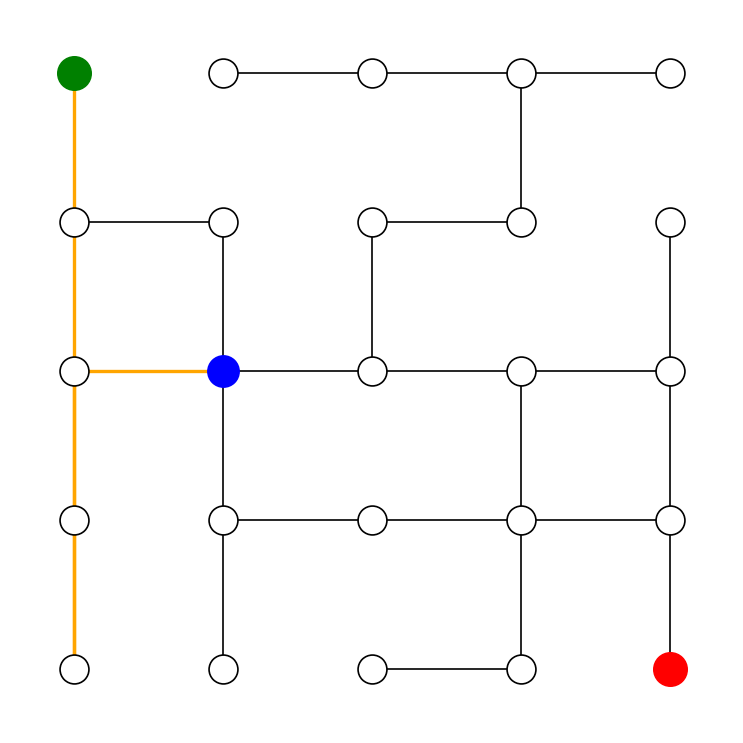

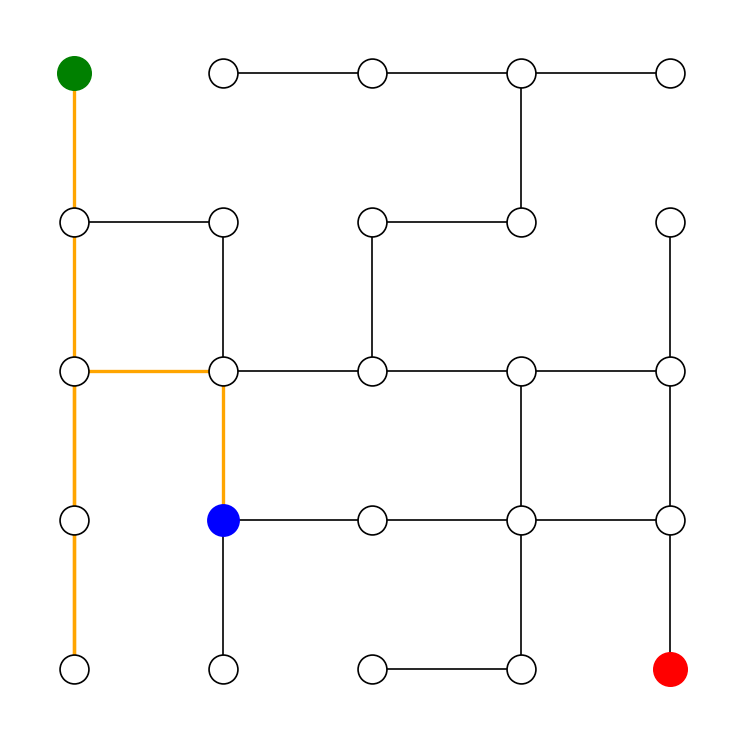

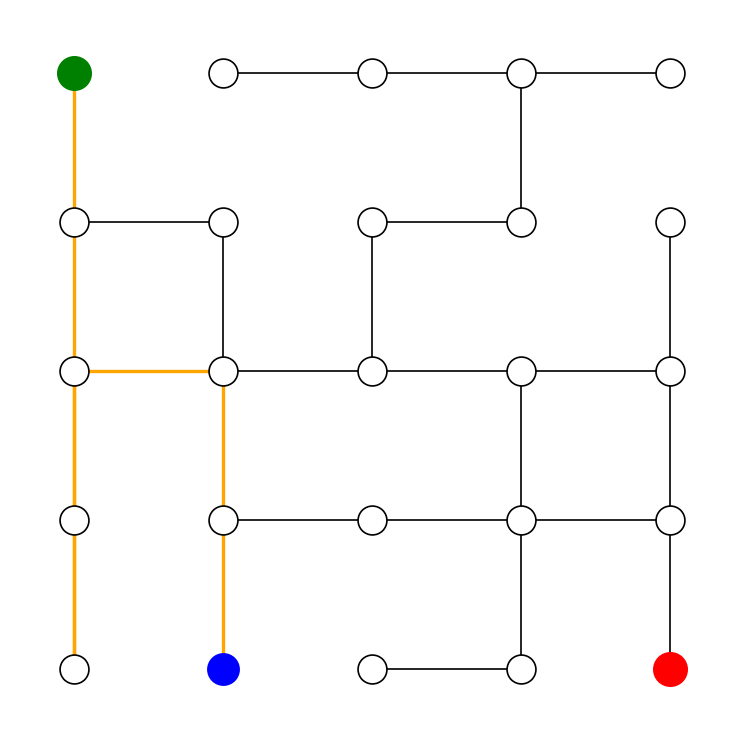

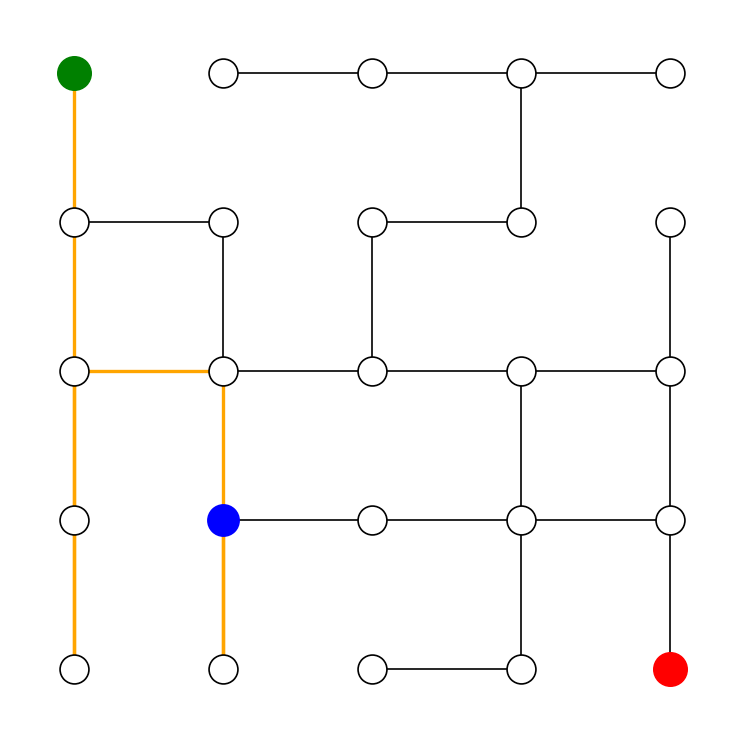

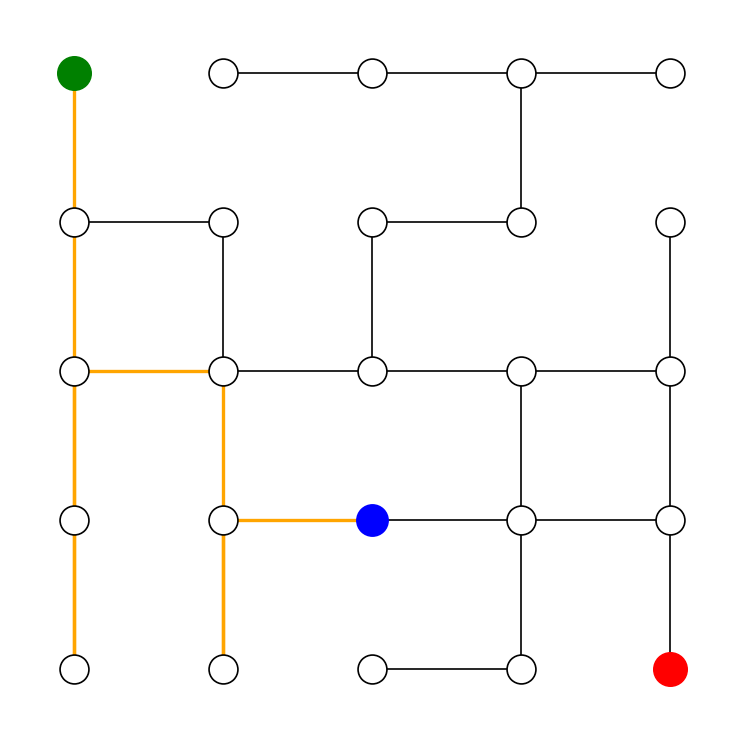

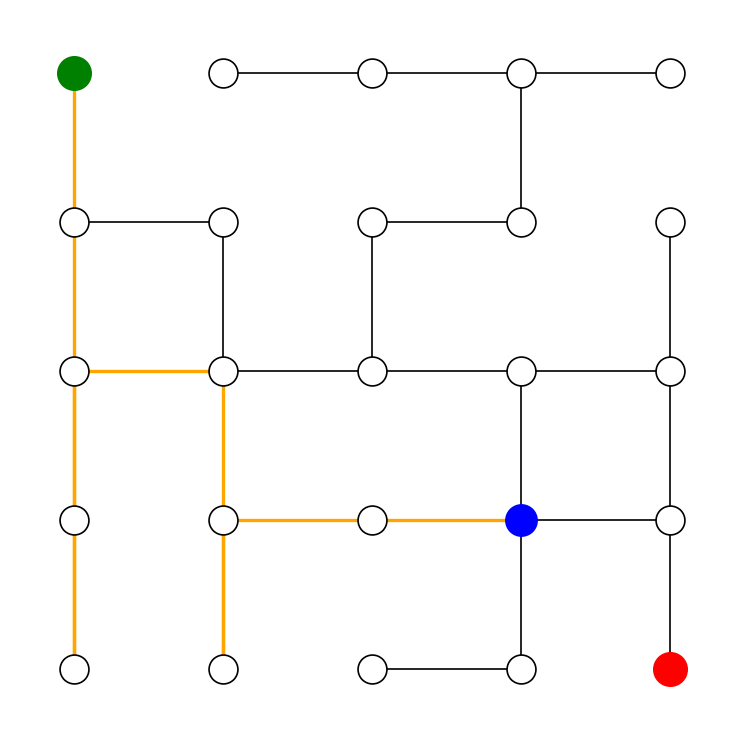

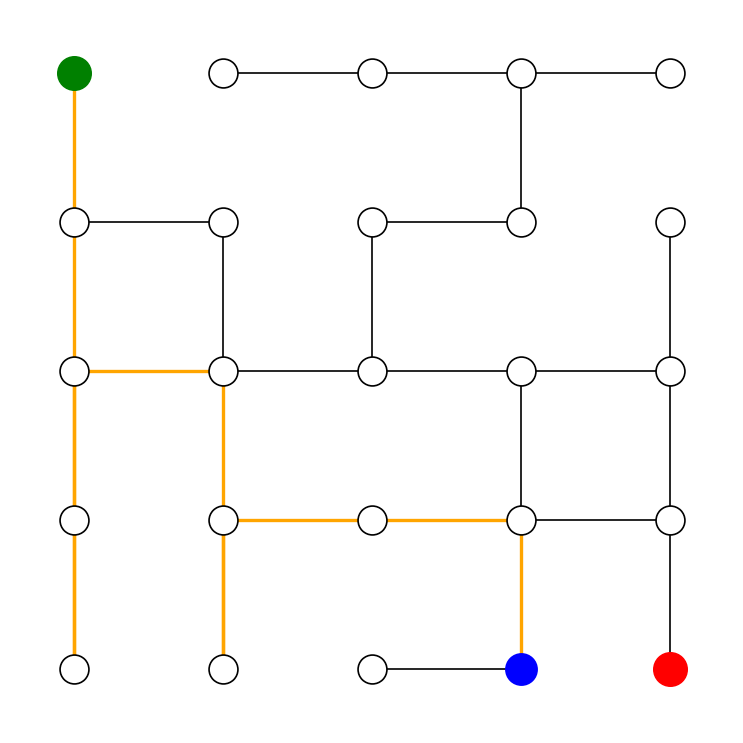

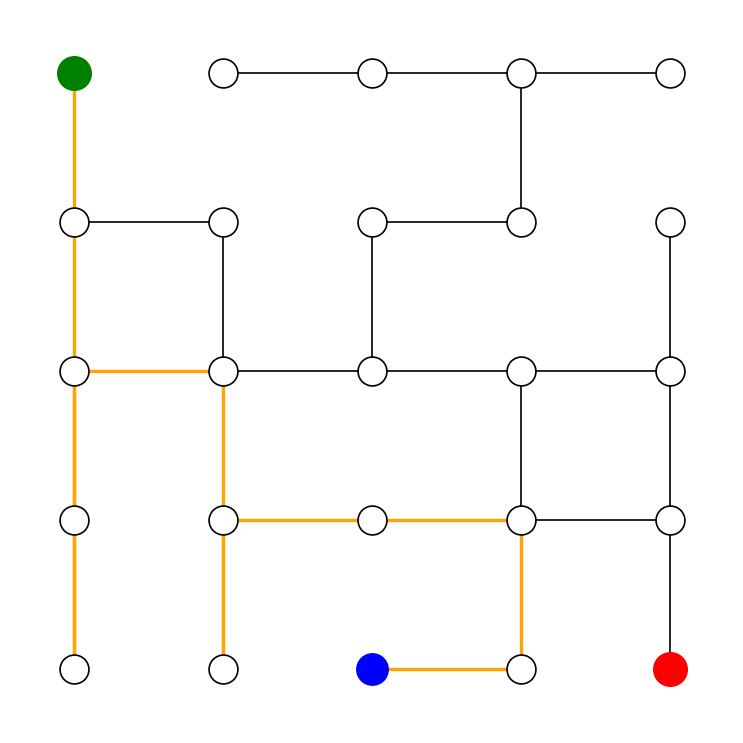

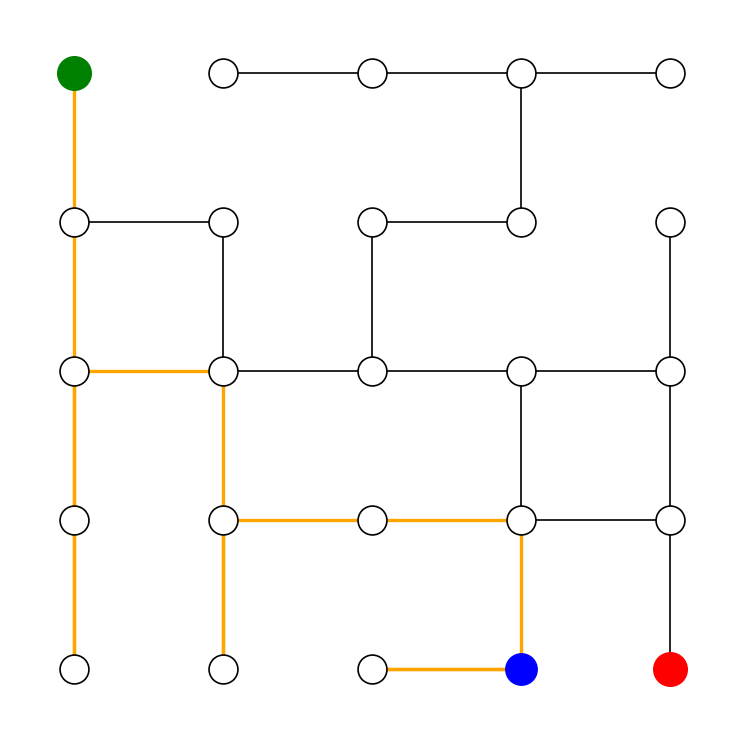

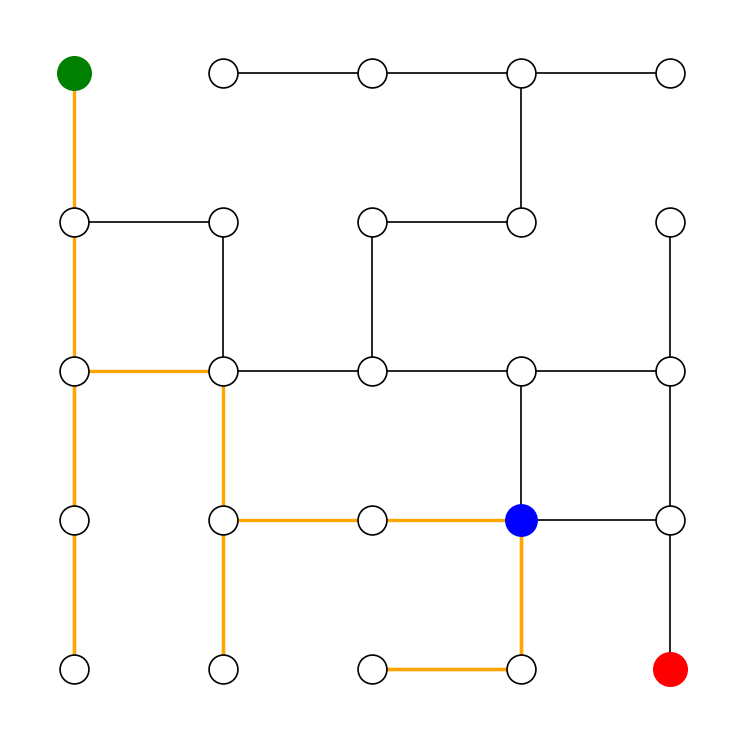

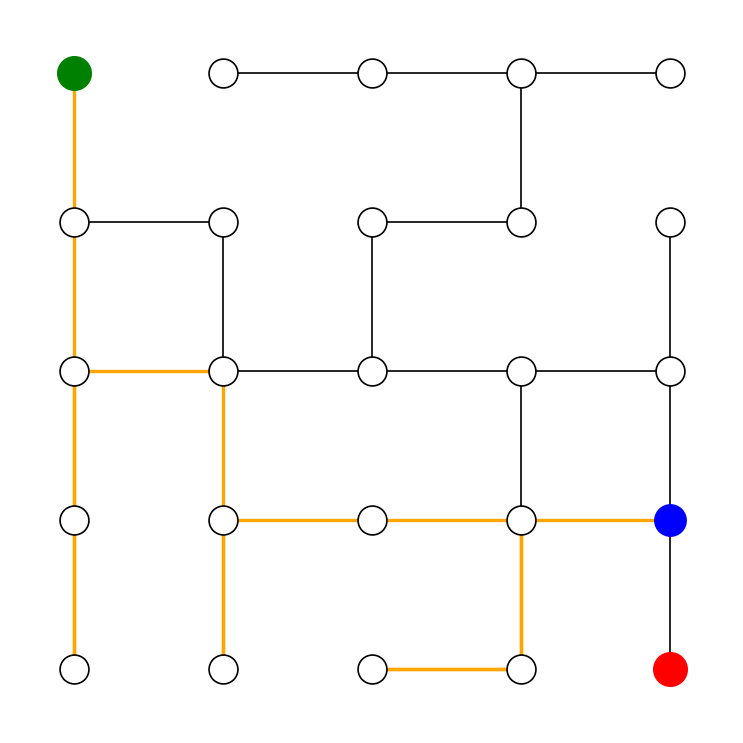

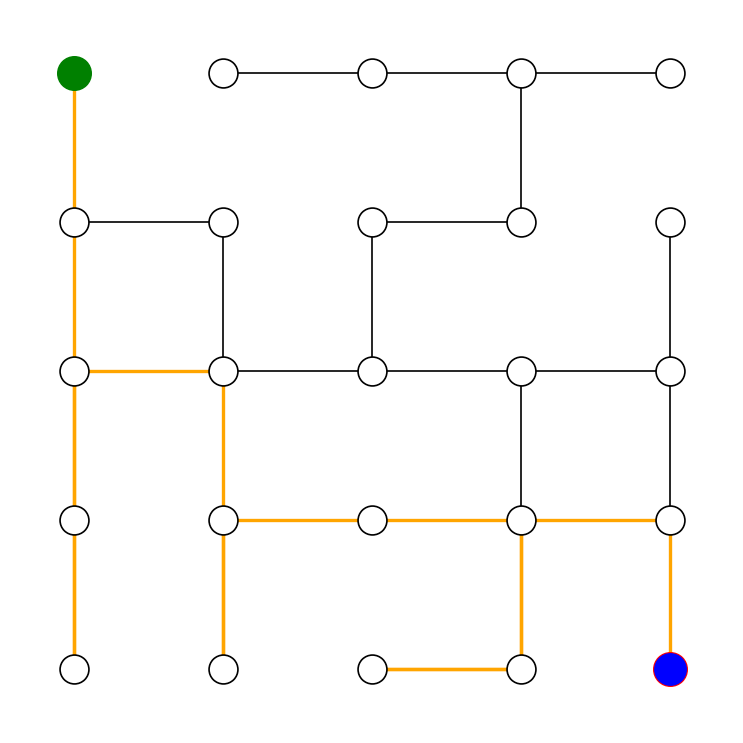

In [17]:
graph_creator = Create_Graph(5, 13)
img = graph_creator.visualization("lab3_graph.png")
display(Image(filename=img))

start = (0, 0)
goal = (4, 4)

agent = Extended_Agent(graph_creator.graph, start, goal)
Agent.animate_path = animate_path
agent.animate_path(delay=0.5)
